<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico 2 </font></h1>
    <h2><font style="bold">Regresión del valor medio de casas en distritos de California</font></h2>
    <h3><font style="bold">Abril Noguera - Pablo Brahim - Fermin Rodriguez - Kevin Pennington</font></h3>
</div>

Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada 
observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

Y el target es:

- `MedHouseVal`: Mediana del costo de casas en el bloque (en unidades de a $100.000)

Para este TP, se proporciona una notebook (`ayuda.ipynb`) con la lectura del dataset, la separación de los datos, entre 
otras ayudas para resolver este trabajo práctico.


In [142]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold

In [143]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df = pd.concat([X, y], axis=1)

----

## Link al Repositorio
Adjunto el link al repositorio con la resulución completa. [Repositorio de Github](https://github.com/abrilnoguera/TP2-IIA)

--- 

### 1.  Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

#### Correlaciones sobre la base completa

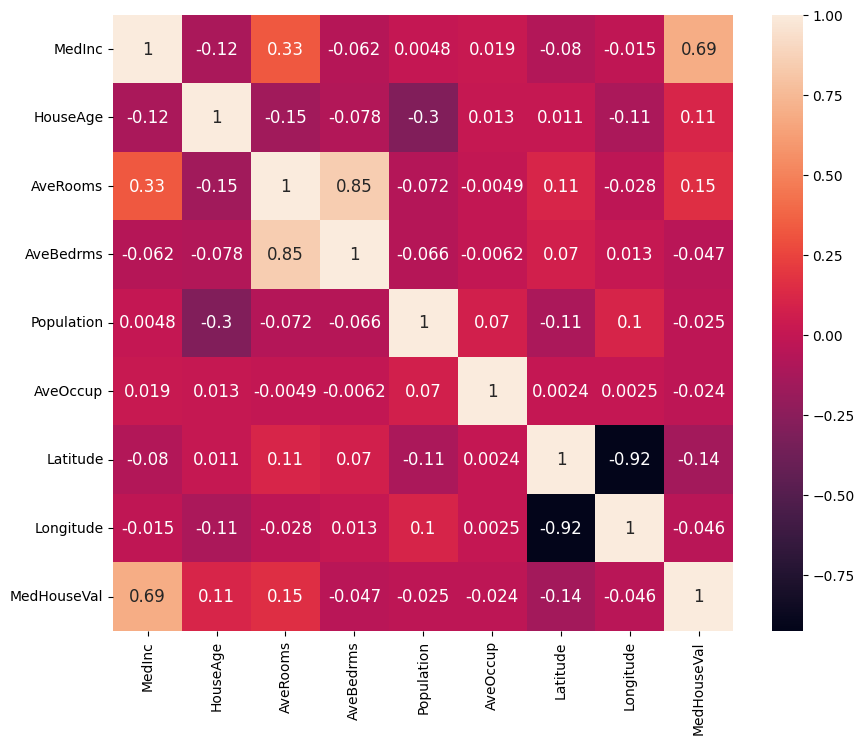

In [144]:
correlations = df.corr()
plt.figure(figsize=[10,8])
sns.heatmap(correlations, annot=True, annot_kws={'size':12})
plt.show()

El atributo con mayor correlación lineal con el target **es el ingreso medio del bloque (MeInc)** con un coeficiente de **0.69**. La correlación es bastante alta lo cual es esperable ya que, a mayor ingreso del bloque, mayor debe ser el costo medio de las propiedades.

Entre los atributos no se observa en general correlaciones muy grandes. El -0.92 es el mayor valor pero es la correlación entre las coordenadas de California, que no refleja una relación causal, sino que responde a la disposición diagonal del Estado. Otra correlación alta entre atributos es la de numero promedio de habitaciones y dormitorios. 
Finalmente, otro valor que resalta es el promedio de habitaciones e ingreso medio del bloque con un coeficiente de 0.33.

#### Correlaciones eliminando outliers

Se calculan nuevamente las correlaciones manuales excluyendo el 1% superior de valores atípicos. 

In [145]:
df.describe(percentiles=[0.01, 0.5, 0.99])

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
1%,1.069631,4.000000,2.581133,0.872840,88.000000,1.536686,32.680000,-123.220000,0.500000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
99%,10.596540,52.000000,10.357033,2.127541,5805.830000,5.394812,40.626100,-116.290000,5.000010
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Las variables **AveRooms, AveBedrms, AveOccup y Population** presentan valores máximos considerablemente más altos que su percentil 99, lo cual indica una fuerte presencia de valores atípicos extremos en estas distribuciones. 

Se excluyeron 207 valores del data frame


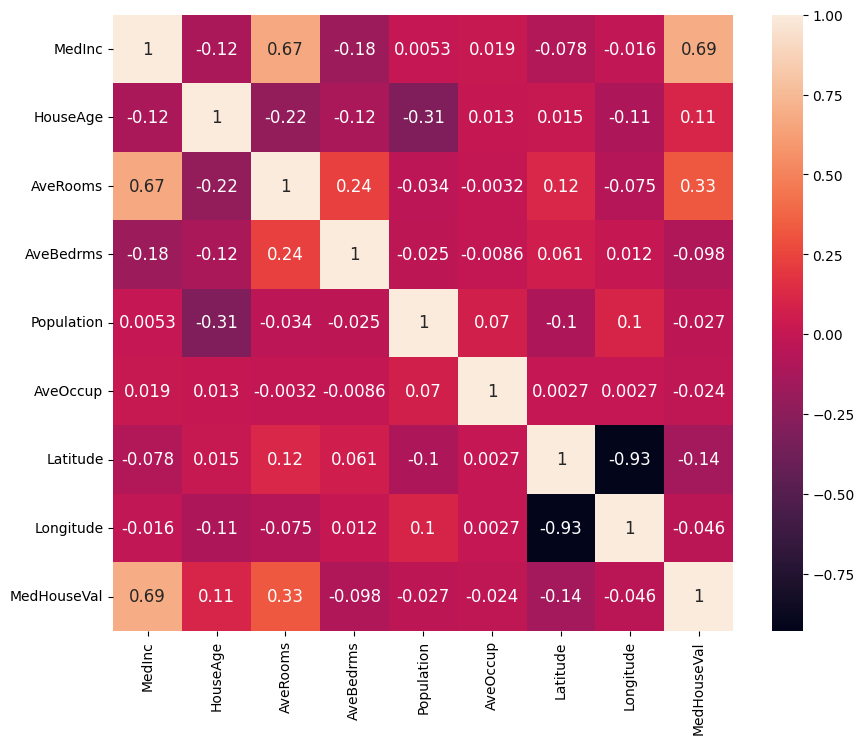

In [146]:
df_aux = df.loc[ (df["AveRooms"] < df.quantile(0.99)["AveRooms"])]
plt.figure(figsize=[10,8])
correlations =df_aux.corr()
sns.heatmap(correlations, annot=True, annot_kws={'size':12})
print(f"Se excluyeron {df.shape[0] - df_aux.shape[0]} valores del data frame")

La correlación entre **AveRooms y MedInc** pasó de 0.33 a 0.67, lo cual indica que los valores atípicos estaban ocultando una relación positiva significativa entre el tamaño promedio de las viviendas y el ingreso medio del bloque.

La relación entre **AveRooms y AveBedrms** se redujo de 0.85 a 0.24, lo que indica que los valores extremos inflaban artificialmente esta relación. Al eliminarlos, se revela que la asociación entre ambas variables no es tan fuerte como parecía inicialmente.

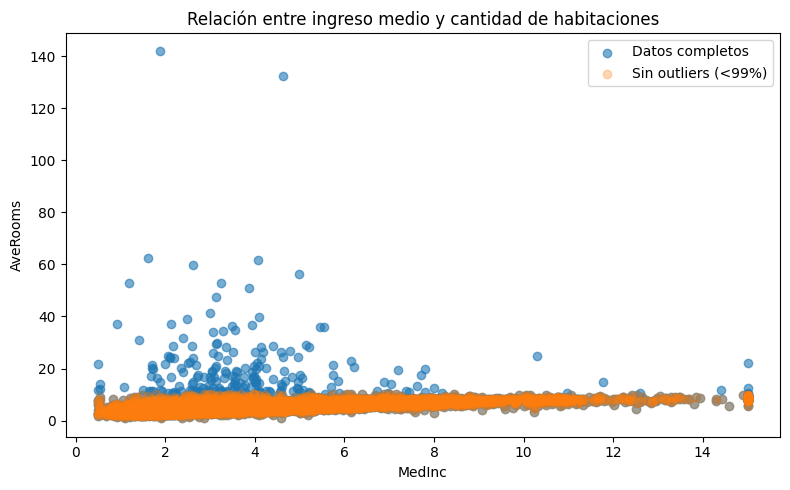

In [147]:
plt.figure(figsize=(8, 5))
plt.scatter(df.MedInc, df.AveRooms, label="Datos completos", alpha=0.6)
plt.scatter(df_aux.MedInc, df_aux.AveRooms, alpha=0.3, label="Sin outliers (<99%)")

plt.xlabel("MedInc")
plt.ylabel("AveRooms")
plt.title("Relación entre ingreso medio y cantidad de habitaciones")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

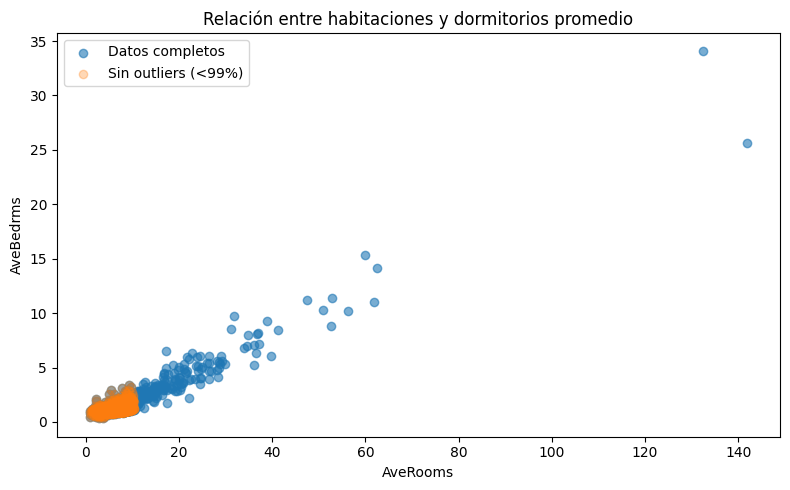

In [148]:
plt.figure(figsize=(8, 5))
plt.scatter(df.AveRooms, df.AveBedrms, label="Datos completos", alpha=0.6)
plt.scatter(df_aux.AveRooms, df_aux.AveBedrms, alpha=0.3, label="Sin outliers (<99%)")

plt.xlabel("AveRooms")
plt.ylabel("AveBedrms")
plt.title("Relación entre habitaciones y dormitorios promedio")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

---
### 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin  entrar en pruebas de hipótesis?

In [149]:
def plot_hist(df, column, quantile=0.99, bins=30):

    threshold = df[column].quantile(quantile)
    df_filtered = df[df[column] < threshold]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[column], ax=axes[0], bins=bins, color="steelblue")
    axes[0].set_title(f"All data — {column}")

    sns.histplot(df_filtered[column], ax=axes[1], bins=bins, color="seagreen", kde=True)
    axes[1].set_title(f"Filtered < {quantile:.0%} — {column}")

    plt.tight_layout()
    plt.savefig("a.png")
    plt.show()

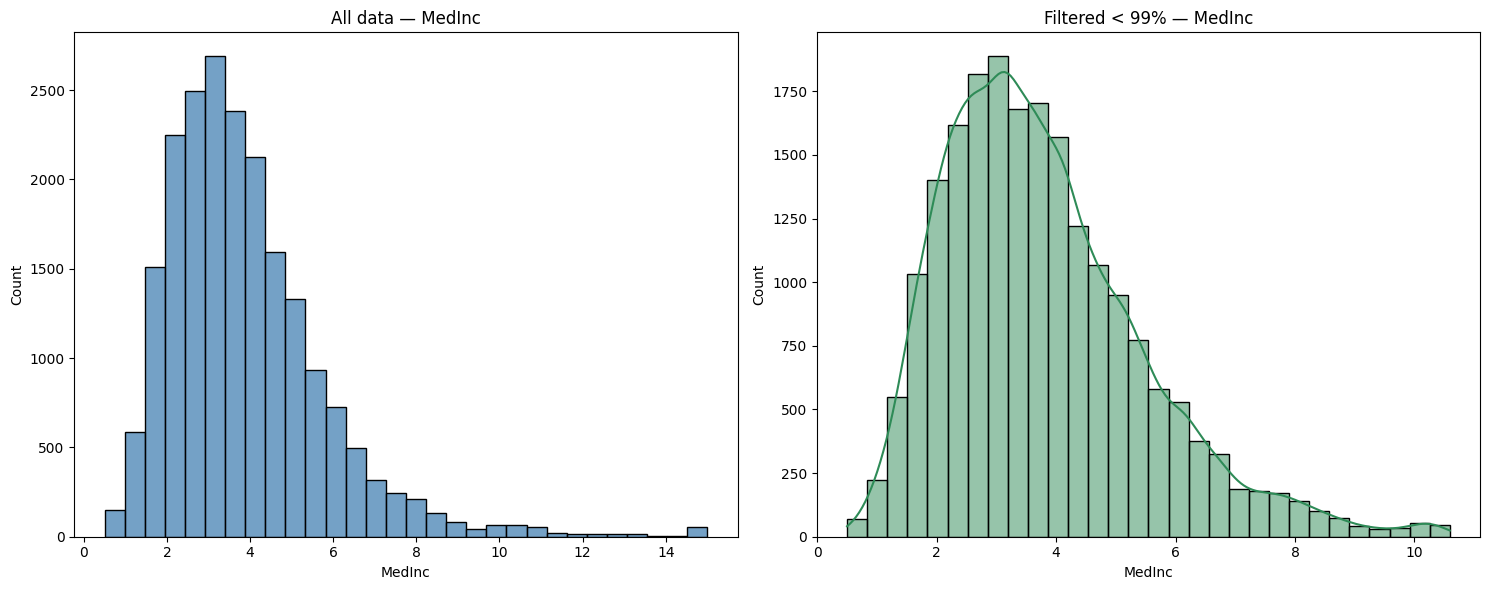

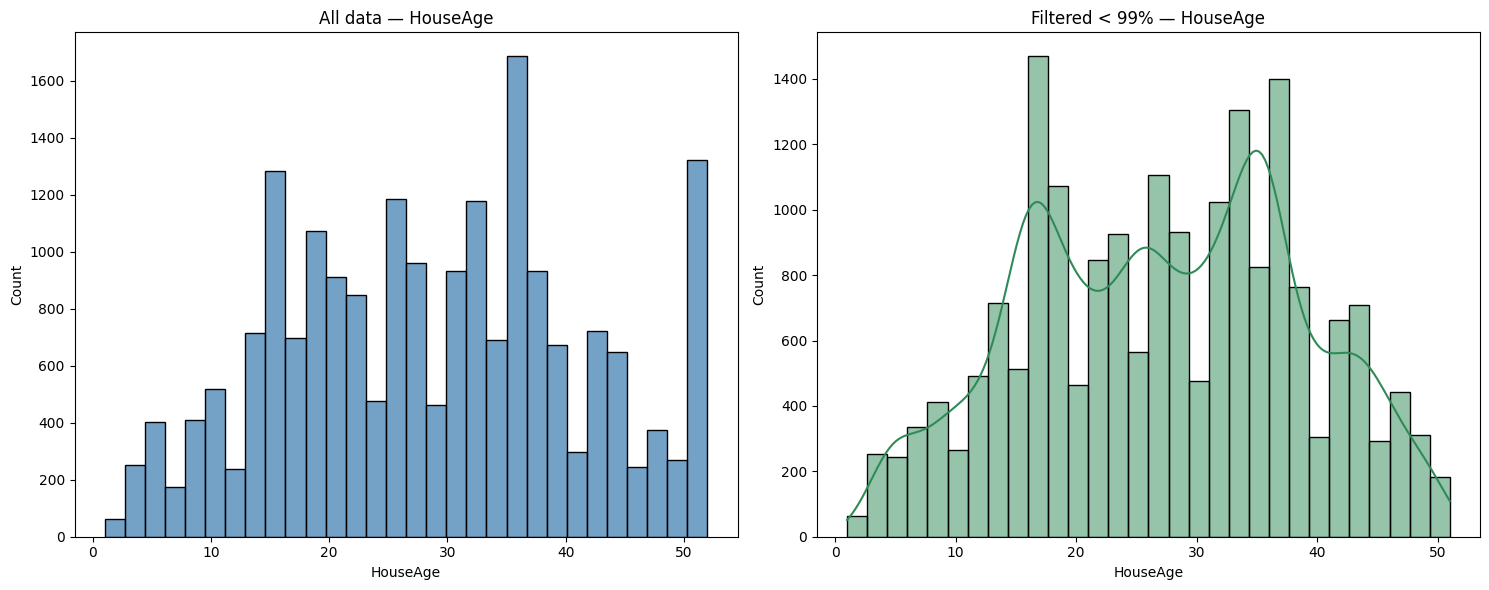

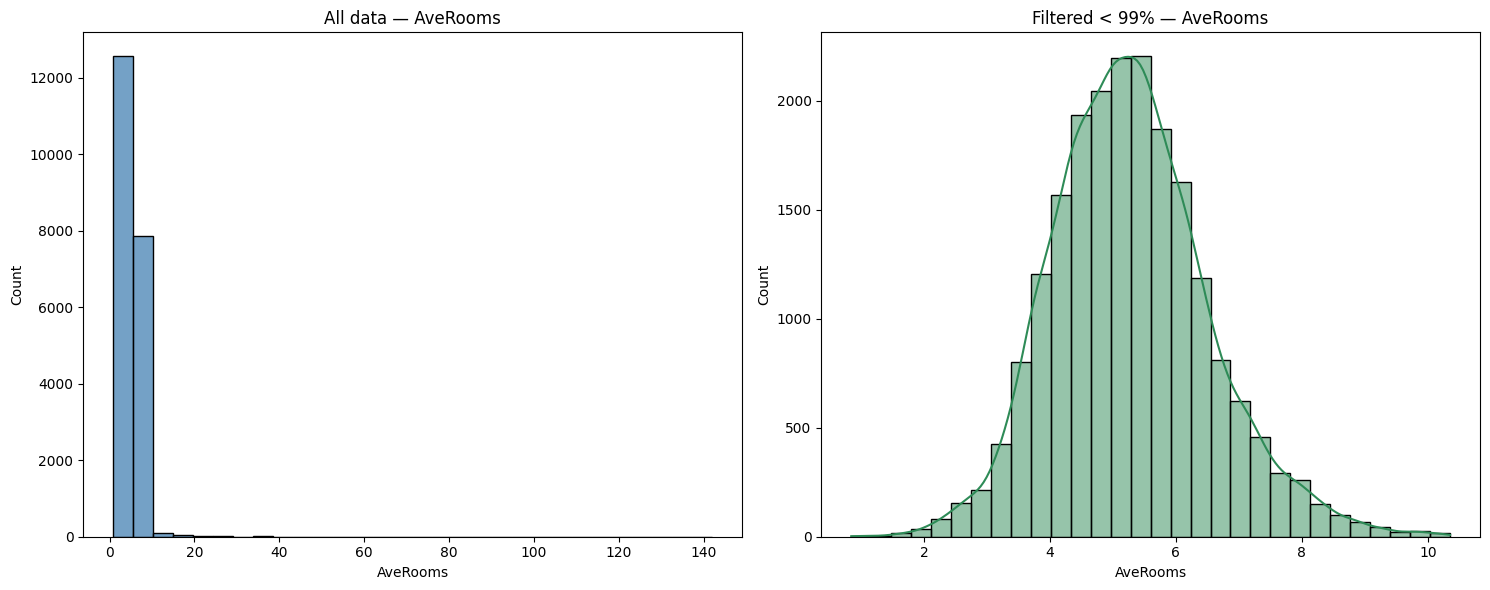

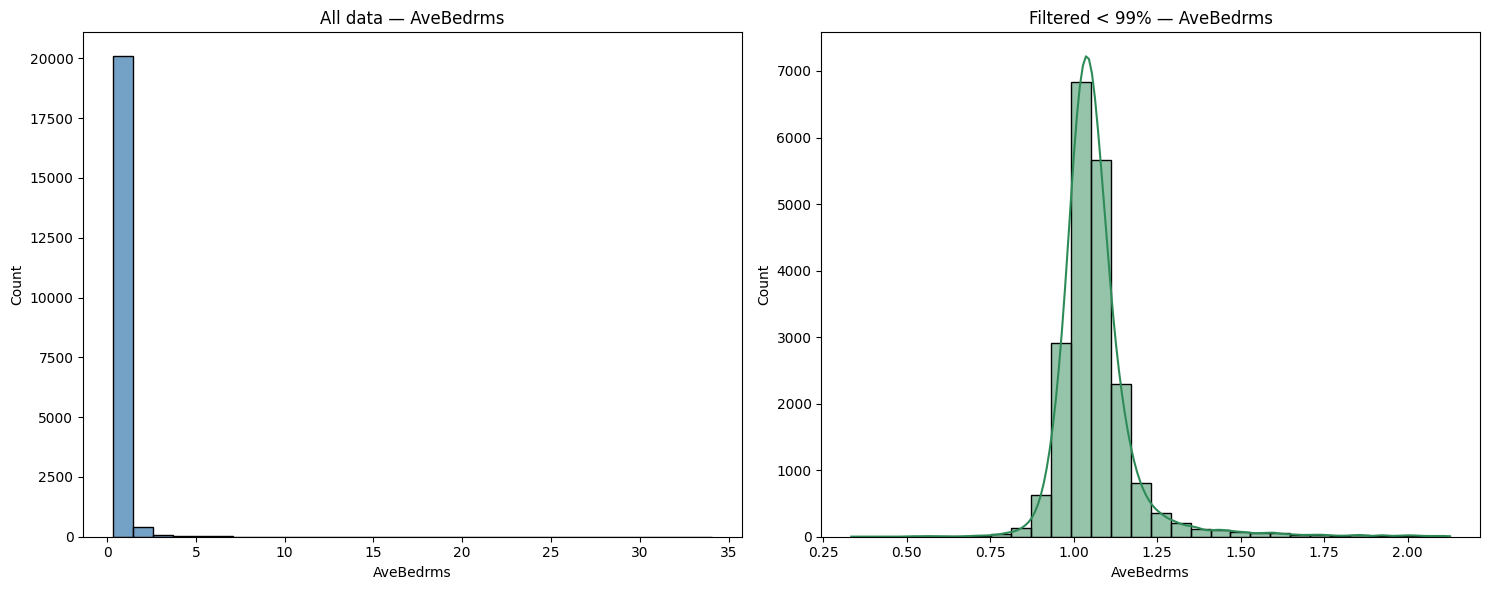

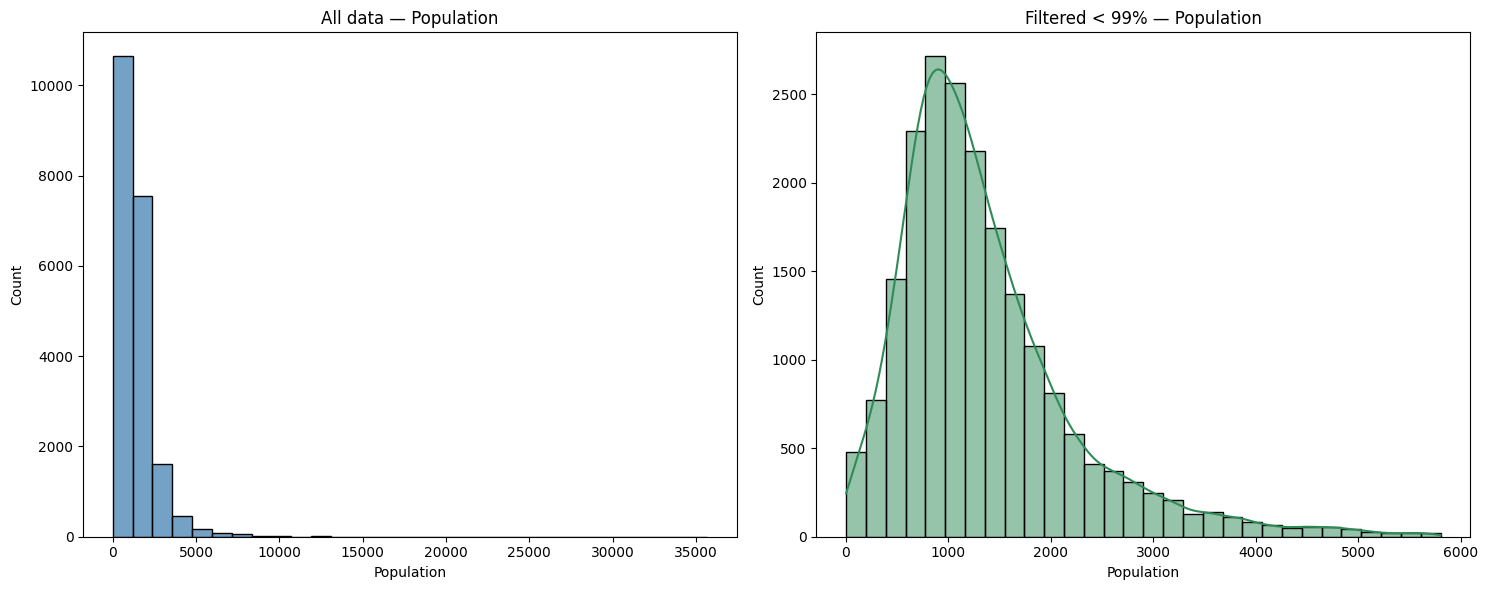

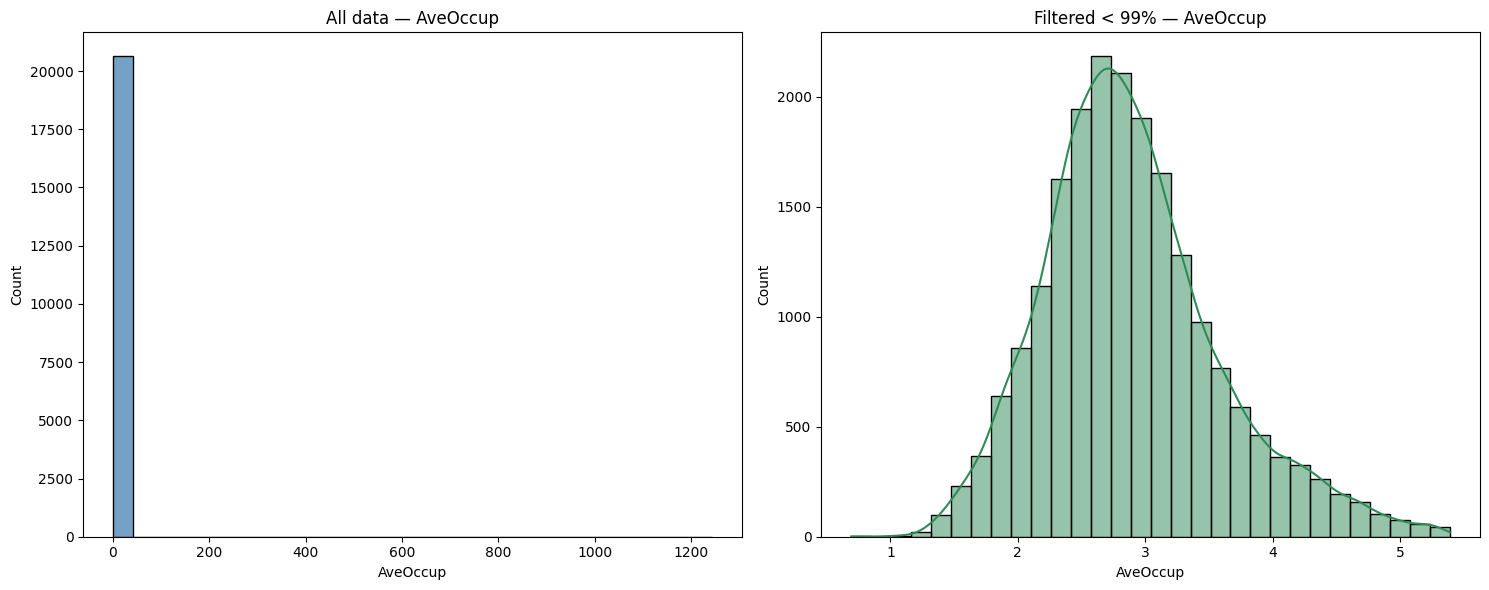

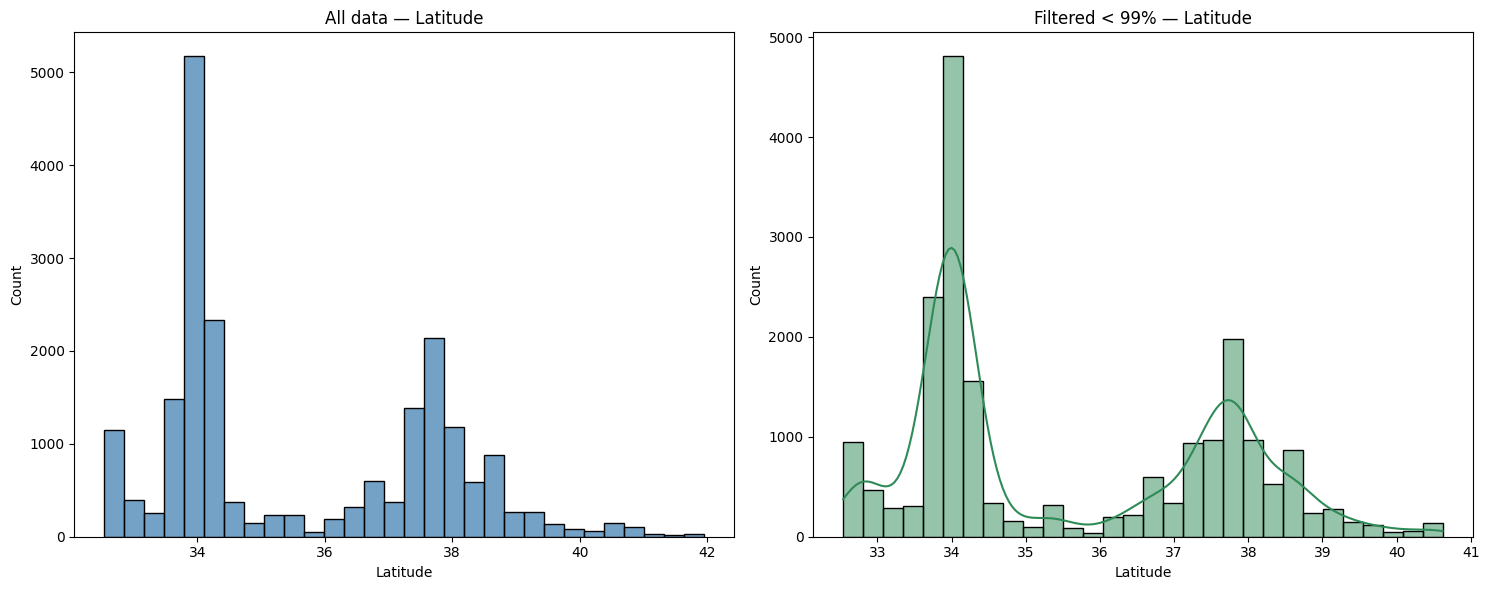

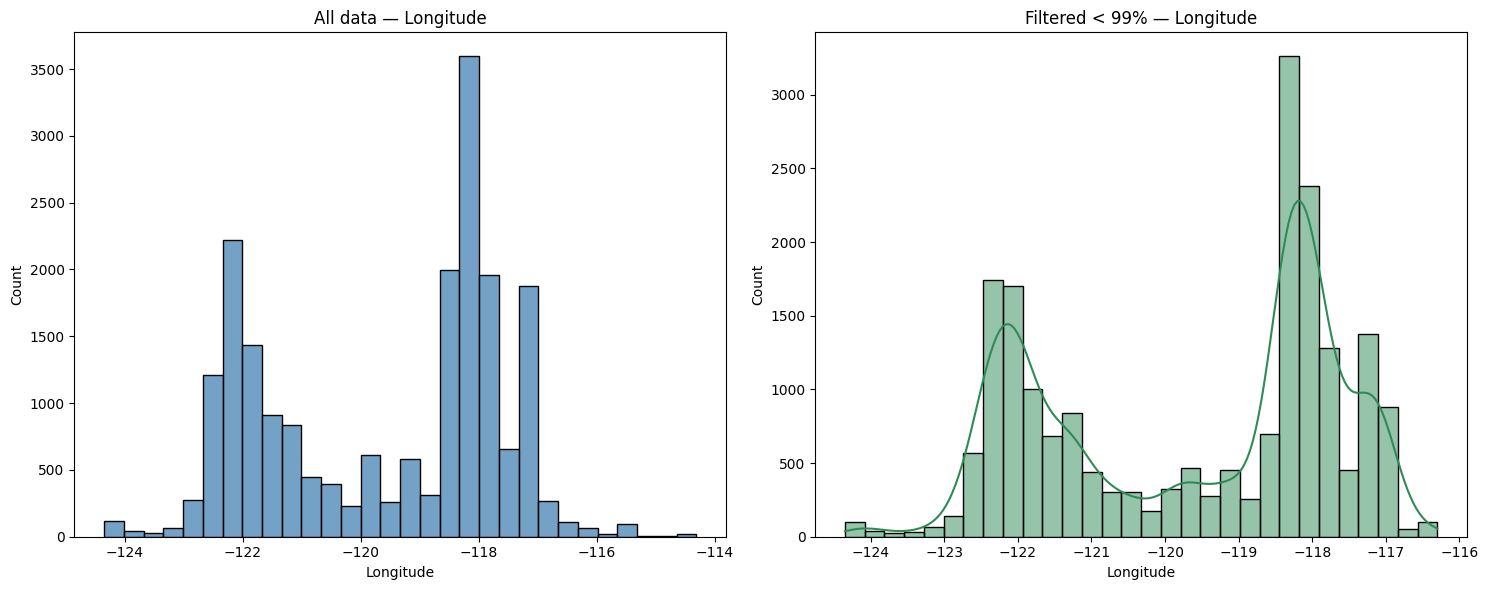

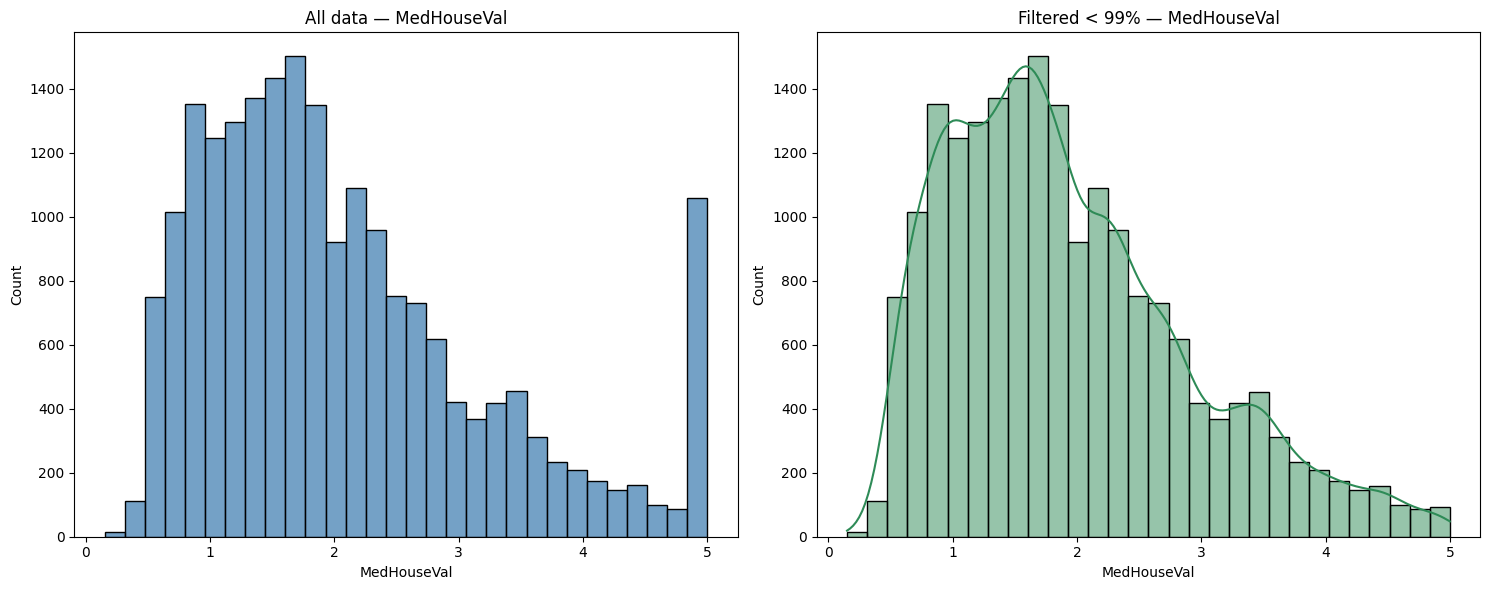

In [150]:
for col in df.columns:
    plot_hist(df,col)

En general (excluyendo latitud y longitud) los datos presentan forma de campana, aunque no se ajustan perfectamente a una distribución normal. Esto se hace mas visible filtrando el 99% inferior de los datos.

Sin embargo, la mayoría de las variables exhiben una asimetría o skew hacia la derecha. **MediaInc, Population y AveOccup** son los atrubutos donde este comportamiento se hace mas evidente. Podrían seguir una distribución log-normal, lo que podria comprobarse aplicando el logaritmo y evaluando si es normal. 

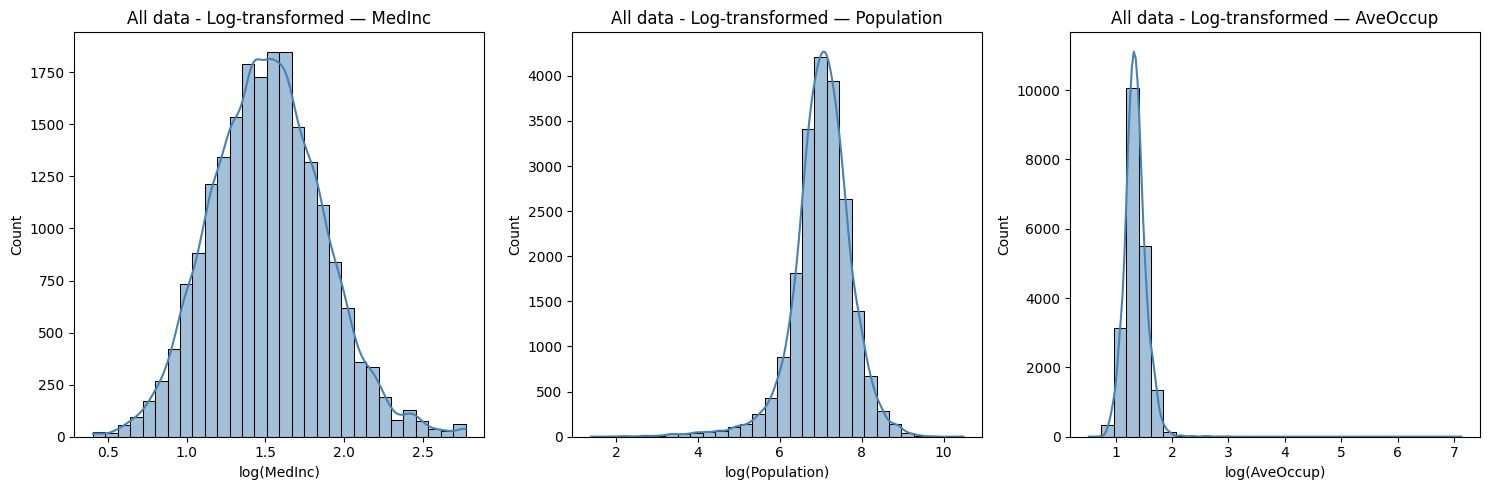

In [151]:
df_log = df[["MedInc", "Population", "AveOccup"]].apply(lambda x: np.log(x + 1))

# Graficamos histogramas de las variables transformadas
plt.figure(figsize=(15, 5))

for i, column in enumerate(df_log.columns):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_log[column], kde=True, bins=30, color='steelblue')
    plt.title(f'All data - Log-transformed — {column}')
    plt.xlabel(f'log({column})')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Al transformar **MedInc** aplicando el logaritmo se presenta una distribución bastante simétrica con forma de campana. La variable ahora se asemeja mucho a una normal.
En cambio las variables **Population y AveOccup** siguen presentando sesgos.

Antes del modelado, se eliminaron los outliers de la variable **AveRooms** (filtrando el 1% superior).

In [152]:
mask = X["AveRooms"] < X["AveRooms"].quantile(0.99)
X_filtered = X[mask].copy()
y_filtered = y[mask].copy()

---
### 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su  respuesta.

In [153]:
# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X_filtered,  y_filtered, test_size=0.3, random_state=42)

In [154]:
# Creamos el pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [155]:
# Entrenamos el modelo
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [156]:
# Predecir y evaluar
y_pred_train = pipe.predict(X_train)

# Calcular varianza total y explicada
var_total = np.var(y_train)
var_residual = np.var(y_train - y_pred_train)
var_explicada = var_total - var_residual
r2 = r2_score(y_train, y_pred_train) # porcentaje de varianza explicada

# Resultados
print("Resultados del modelo en Train:")
print(f"Varianza total del target: {var_total:.4f}")
print(f"Varianza explicada por el modelo: {var_explicada:.4f}")
print(f"R²: {r2:.2%}")

Resultados del modelo en Train:
Varianza total del target: 1.3254
Varianza explicada por el modelo: 0.8170
R²: 61.64%


El modelo está explicando un **58.71%** de la variabilidad del target, lo cual no es perfecto pero tampoco bajo. Esto quiere decir que, aunque el modelo logra reconocer ciertos patrones importantes en los datos, todavía hay una parte considerable que no está pudiendo explicar. Es decir, hay aspectos del comportamiento del target que el modelo no está captando del todo.

---
### 4. Calcular las métricas de MSE, MAE y $R^2$ del set de evaluación.

In [157]:
# 1. Predecir sobre el set de test
y_pred = pipe.predict(X_test)

# 2. Calcular métricas
mse_reg = mean_squared_error(y_test, y_pred)
mae_reg = mean_absolute_error(y_test, y_pred)
r2_reg = r2_score(y_test, y_pred)

# 3. Mostrar resultados
print("Resultados del modelo en Test:")
print(f"MSE (Error cuadrático medio): {mse_reg:.4f}")
print(f"MAE (Error absoluto medio):  {mae_reg:.4f}")
print(f"R² (Varianza explicada):     {r2_reg:.2%}")

Resultados del modelo en Test:
MSE (Error cuadrático medio): 0.5186
MAE (Error absoluto medio):  0.5248
R² (Varianza explicada):     61.50%


El desempeño del modelo sobre el conjunto de test es coherente con lo observado en entrenamiento. El R² de **58.64%** indica que el modelo mantiene una capacidad de generalización razonable, aunque puede mejorar.

---
### 5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de $\alpha$, buscando entre [0, 12.5]. Graficar el valor de MSE versus $\alpha$.

In [158]:
# Definimos el rango de alphas
alphas = np.linspace(0, 12.5, 100)

# Creamos el pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Definimos los hiperparámetros a testear
param_grid = {'regressor__alpha': alphas}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch con scoring de MSE (negativo)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': array([ 0.        ,  0.12626263,  0.25252525,  0.37878788,  0.50505051,
        0.63131313,  0.75757576,  0.88383838,  1.01010101,  1.13636364,
        1.26262626,  1.38888889,  1.51515152,  1.64141414,  1.76767677,
        1.89393939,  2.0...
        8.83838384,  8.96464646,  9.09090909,  9.21717172,  9.34343434,
        9.46969697,  9.5959596 ,  9.72222222,  9.84848485,  9.97474747,
       10.1010101 , 10.22727273, 10.35353535, 10.47979798, 10.60606061,
       10.73232323, 10.85858586, 10.98484848, 11.11111111, 11.23737374,
       11.36363636, 11.48989899, 11.61616162, 11.74242424, 11.86868687,
       11.99494949, 12.12121212, 12.24747475, 12.37373737, 12.5       ])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [159]:
best_alpha = grid.best_params_['regressor__alpha']
print("Mejor alpha:", best_alpha)

Mejor alpha: 12.5


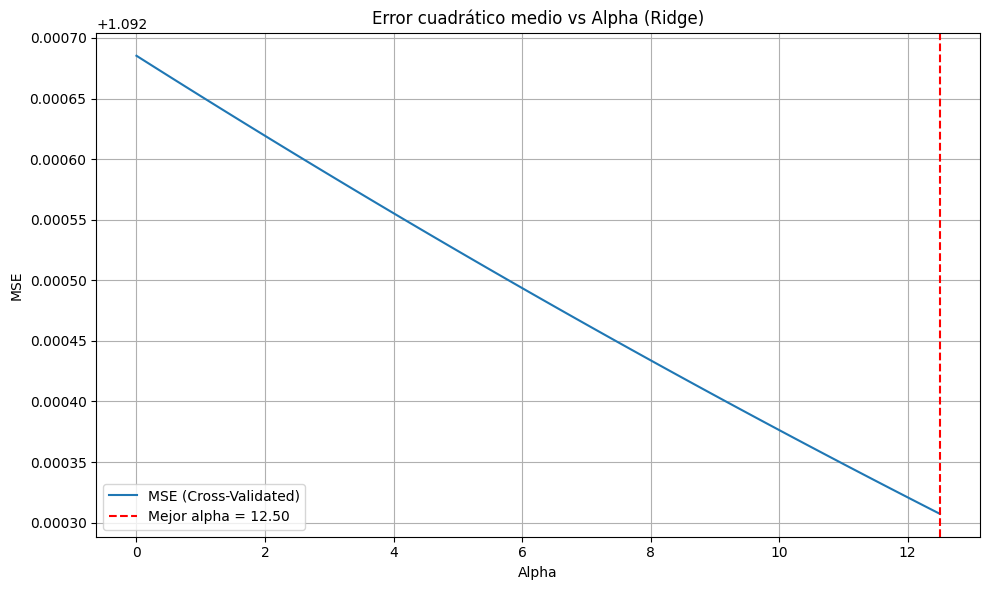

In [160]:
# Obtenemos los MSEs negativos y los convertimos a positivos
mean_mse = -grid.cv_results_['mean_test_score']

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_mse, label='MSE (Cross-Validated)')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Mejor alpha = {best_alpha:.2f}')
plt.title('Error cuadrático medio vs Alpha (Ridge)')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Forzar que matplotlib no use offset notation
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

El gráfico muestra una tendencia descendente del error cuadrático medio (MSE) a medida que el valor de alpha aumenta dentro del rango [0, 12.5]. Esto indica que el modelo se beneficia de una mayor regularización, ya que el MSE sigue disminuyendo en ese intervalo. El valor óptimo hallado (alpha = 12.5) está en el extremo superior del rango explorado, lo que sugiere que probablemente no se ha alcanzado el mínimo global del MSE.

In [161]:
# Entrenamos el modelo final con ese alpha
modelo_final = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=best_alpha))
])

modelo_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=np.float64(12.5)))])

In [162]:
# Predecir y evaluar
y_pred_train = modelo_final.predict(X_train)

# Calcular varianza total y explicada
var_total = np.var(y_train)
var_residual = np.var(y_train - y_pred_train)
var_explicada = var_total - var_residual
r2 = r2_score(y_train, y_pred_train) # porcentaje de varianza explicada

# Resultados
print("Resultados del modelo en Train:")
print(f"Varianza total del target: {var_total:.4f}")
print(f"Varianza explicada por el modelo: {var_explicada:.4f}")
print(f"R²: {r2:.2%}")

Resultados del modelo en Train:
Varianza total del target: 1.3254
Varianza explicada por el modelo: 0.8169
R²: 61.64%


El modelo entrenado con regresión Ridge y el mejor valor de regularización (alpha) obtenido por validación cruzada logra explicar el **61.64%** de la variabilidad del target en el conjunto de entrenamiento

In [163]:
# 1. Predecir sobre el set de test
y_pred = modelo_final.predict(X_test)

# 2. Calcular métricas
mse_ridge = mean_squared_error(y_test, y_pred)
mae_ridge = mean_absolute_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)

# 3. Mostrar resultados
print("Resultados del modelo en Test:")
print(f"MSE (Error cuadrático medio): {mse_ridge:.4f}")
print(f"MAE (Error absoluto medio):  {mae_ridge:.4f}")
print(f"R² (Varianza explicada):     {r2_ridge:.2%}")

Resultados del modelo en Test:
MSE (Error cuadrático medio): 0.5187
MAE (Error absoluto medio):  0.5247
R² (Varianza explicada):     61.49%


El modelo muestra un rendimiento muy similar al observado en el conjunto de entrenamiento, con un R² de **61.49%**.

---
### 6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

In [164]:
# Comparación
print("Comparación en set de evaluación:\n")
print(f"{'Métrica':<10}{'Lineal':<10}{'Ridge':<10}{'Mejora (%)':<10}")
print(f"{'-'*40}")
print(f"{'MSE':<10}{mse_reg:.4f}{mse_ridge:>10.4f}{(mse_reg-mse_ridge)/mse_reg*100:>10.2f}%")
print(f"{'MAE':<10}{mae_reg:.4f}{mae_ridge:>10.4f}{(mae_reg-mae_ridge)/mae_reg*100:>10.2f}%")
print(f"{'R²':<10}{r2_reg:.2%}{r2_ridge:>10.2%}{(r2_ridge-r2_reg)*100:>10.2f}pp")

Comparación en set de evaluación:

Métrica   Lineal    Ridge     Mejora (%)
----------------------------------------
MSE       0.5186    0.5187     -0.02%
MAE       0.5248    0.5247      0.01%
R²        61.50%    61.49%     -0.01pp


En este caso, la regresión Ridge no logra mejorar significativamente los resultados respecto a la regresión lineal. Las métricas obtenidas en el set de evaluación son prácticamente idénticas: el MSE y MAE varían en menos de un 0.02%, y el R² es prácticamente el mismo (61.50% vs. 61.49%).

Esto sugiere que la regularización introducida por Ridge no aporta beneficios relevantes en este escenario, posiblemente porque:
- El modelo lineal ya tiene un buen ajuste sin signos de sobreajuste.
- No hay colinealidades fuertes que perjudiquen el entrenamiento.
- El número de variables es moderado y el preprocesamiento fue efectivo.

# Link al Notebook
Se puede encontrar el trabajo completo en el siguiente link: [Repositorio GitHub](https://github.com/abrilnoguera/TP2-IIA)